# Subclass Distillation Demo Colab

This Colab trains a convolutional network on MNIST collapsed to 2 classes (0-4 and 5-9) with 10 subclasses, and then distills into a narrow fully connected network.

---

Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

Please cite as:

    @article{muller2020subclass,
      title={Subclass distillation},
      author={M{\"u}ller, Rafael and Kornblith, Simon and Hinton, Geoffrey},
      journal={arXiv preprint arXiv:2002.03936},
      year={2020}
    }

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 2  # 2 total classes.
NUM_SUBCLASSES = 10  # 10 total subclasses (5 subclasses/class).

## Define Subclass Losses

In [ ]:
def class_logits_from_subclass_logits(
    subclass_logits: tf.Tensor, num_classes: int) -> tf.Tensor:
  """Compute class logits from subclass logits.

  This function computes `logsumexp` over the subclasses corresponding to each
  dataset class to yield class logits. We work in log space for numerical
  stability, but `softmax(class_logits)` yields the same probabilities as
  summing `softmax(subclass_logits)` over the subclasses corresponding to eac
  dataset class.

  Args:
    subclass_logits: A Tensor of shape `[batch_size, num_subclasses]` of
      subclass logits. `num_subclasses` must be a multiple of `num_classes`.
    num_classes: Number of output classes.

  Returns:
    A Tensor of shape `[batch_size]` containing per-example losses.
  """
  # Check arguments.
  if subclass_logits.shape.rank != 2:
    raise ValueError('`subclass_logits` must be a Tensor of rank 2.')
  num_subclasses = int(subclass_logits.shape[-1])
  if num_subclasses % num_classes != 0:
    raise ValueError(
        'Number of subclasses in `subclass_logits` must be a multiple of '
        'number of classes in `labels`.')

  # Compute cross entropy loss after performing LogSumExp over subclass logits
  # corresponding to each class. This is equivalent to summing their
  # probabilities but maintains the stability advantages of working with logits.
  subclass_logits = tf.reshape(
      subclass_logits, (-1, num_classes, num_subclasses // num_classes))
  return tf.math.reduce_logsumexp(subclass_logits, -1)


def negative_sampling_loss(
    subclass_logits: tf.Tensor, temperature: Union[float, tf.Tensor],
    device_context=None, epsilon: Union[float, tf.Tensor] = 1e-9):
  """Negative sampling loss for subclass distillation.

  This auxiliary loss is applied to the teacher to encourage the model to use
  all subclasses. It penalizes high correlation between the logits in a given
  minibatch.

  Args:
    subclass_logits: A Tensor of shape `[batch_size, num_subclasses]` of
      subclass logits.
    temperature: Temperature of negative sampling loss. Usually less than 1.
    device_context: Instance of `TPUContext` or `None`. If provided, the
      negative sampling loss will be computed using logits from all TPU
      replicas. When using TPUEstimator, the device context is provided to the
      `model_fn` as `params['context']`.
    epsilon: Small float used to avoid dividing by 0.

  Returns:
    A scalar Tensor containing the overall loss.
  """
  if subclass_logits.shape.rank != 2:
    raise ValueError('`subclass_logits` must be a Tensor of rank 2.')
  temperature = tf.convert_to_tensor(temperature, dtype=subclass_logits.dtype)
  epsilon = tf.convert_to_tensor(epsilon, dtype=subclass_logits.dtype)
  batch_size = tf.cast(tf.shape(subclass_logits)[0], subclass_logits.dtype)
  num_subclasses = tf.convert_to_tensor(int(subclass_logits.shape[-1]),
                                        dtype=subclass_logits.dtype)

  # Subtract per-example (not batch) mean and variance from subclass logits.
  mean, variance = tf.nn.moments(subclass_logits, -1, keepdims=True)
  normalized_logits = tf.nn.batch_normalization(
      subclass_logits,
      mean=mean,
      variance=variance,
      offset=None,
      scale=1. / tf.sqrt(temperature * num_subclasses),
      variance_epsilon=epsilon)

  scaled_correlations = tf.linalg.matmul(
      normalized_logits, normalized_logits, transpose_b=True)
  return (tf.math.reduce_mean(tf.math.reduce_logsumexp(scaled_correlations, -1))
          - 1 / temperature - tf.math.log(batch_size))


def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the overall loss.
  """
  soft_targets = tf.nn.softmax(
      tf.stop_gradient(teacher_logits) / temperature, -1)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

## Data Loading and Model Construction

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  labels = tf.reduce_sum(
      tf.reshape(labels, (NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES)), -1)
  return image, labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  subclass_logits = model(images, training=False)
  class_logits = class_logits_from_subclass_logits(
      subclass_logits, NUM_CLASSES)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32))

## Teacher Training

In [ ]:
#@test {"output": "ignore"}

# Hyperparameters for teacher training.
BETA = 1.0
NEGATIVE_SAMPLING_TEMPERATURE = 1.0

# Build CNN teacher.
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(NUM_SUBCLASSES))


@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass distillation teacher loss for given images and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for superclasses.
  class_logits = class_logits_from_subclass_logits(
      subclass_logits, NUM_CLASSES)
  cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels, class_logits))

  # Compute negative sampling loss to distribute logits.
  negative_sampling_loss_value = negative_sampling_loss(
      subclass_logits, NEGATIVE_SAMPLING_TEMPERATURE)

  return cross_entropy_loss_value + BETA * negative_sampling_loss_value


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  optimizer = tf.keras.optimizers.Adam()
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num_correct += compute_num_correct(model, images, labels)

    print('{:.2f}%'.format(float(num_correct) / num_total * 100))


train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: 97.13%
Epoch 2: 98.28%
Epoch 3: 98.64%
Epoch 4: 98.85%
Epoch 5: 98.86%
Epoch 6: 98.94%
Epoch 7: 99.28%
Epoch 8: 99.28%
Epoch 9: 99.22%
Epoch 10: 99.25%
Epoch 11: 99.38%
Epoch 12: 99.35%


### Subclasses

Each column in the figure corresponds to a learned subclass. While not perfect, the digits roughly organize by the class in the original dataset.

(-0.5, 279.5, 167.5, -0.5)

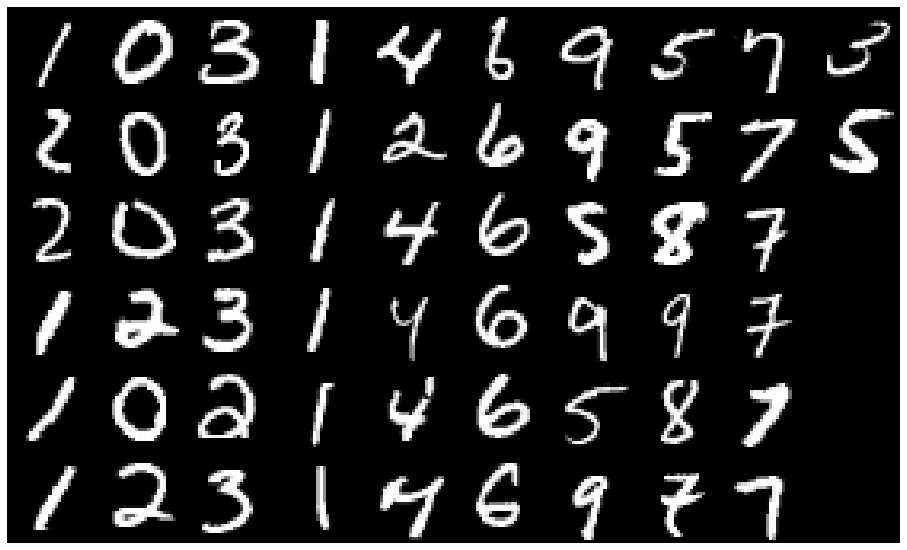

In [ ]:
#@test {"output": "ignore"}

import numpy as np
from matplotlib import pyplot as plt

for images, labels in mnist_train:
  sc_logits = cnn_model(images)
  break

np_images = images.numpy()
subclass_images = np.zeros((np_images.shape[1] * 6, NUM_SUBCLASSES,
                            np_images.shape[2]))
for i in range(NUM_SUBCLASSES):
  images_for_subclass = np_images[np.argmax(sc_logits, -1) == i][:6, :, :, 0]
  images_for_subclass = images_for_subclass.reshape((-1, np_images.shape[2]))
  subclass_images[:images_for_subclass.shape[0], i, :] = images_for_subclass

plt.gcf().set_size_inches((16, 10))
plt.imshow(subclass_images.reshape(subclass_images.shape[0], -1), cmap='gray')
plt.axis('off')

## Student Training

### Distill to Student

After subclass distillation, the student performs nearly as well as the teacher.

In [ ]:
#@test {"output": "ignore"}

# Hyperparameters for distillation.
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 4.

# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(NUM_SUBCLASSES))

# We copy the student before it is trained and use it below.
fc_model_no_distillation = tf.keras.Sequential()
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(NUM_CLASSES))

fc_model_conventional_distillation = tf.keras.models.clone_model(
    fc_model_no_distillation)

def compute_student_loss(images, labels):
  """Compute subclass distillation student loss for given images and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute distillation loss between student subclass logits and softened
  # teacher subclass targets probabilities.
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(
      teacher_logits=teacher_subclass_logits,
      student_logits=student_subclass_logits,
      temperature=DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  student_class_logits = class_logits_from_subclass_logits(
      student_subclass_logits, NUM_CLASSES)
  cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))

  return (ALPHA * distillation_loss_value +
          (1 - ALPHA) * cross_entropy_loss_value)


train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: 98.00%
Epoch 2: 98.51%
Epoch 3: 98.85%
Epoch 4: 98.85%
Epoch 5: 98.96%
Epoch 6: 98.98%
Epoch 7: 98.95%
Epoch 8: 98.99%
Epoch 9: 98.99%
Epoch 10: 98.96%
Epoch 11: 99.02%
Epoch 12: 99.01%


### Train Student from Scratch

When trained from scratch, the student performs substantially worse.

In [ ]:
#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: 97.87%
Epoch 2: 98.13%
Epoch 3: 98.24%
Epoch 4: 97.71%
Epoch 5: 98.25%
Epoch 6: 98.58%
Epoch 7: 98.32%
Epoch 8: 98.39%
Epoch 9: 98.47%
Epoch 10: 98.51%
Epoch 11: 98.54%
Epoch 12: 98.53%


### Conventional Distillation from Binary Predictions

Baseline: distillation from logits.
It performs better than training the student from scratch, but worse than subclass distillation.


In [ ]:
#@test {"output": "ignore"}

def compute_conventional_distillation_loss(images, labels):
  """Compute distillation student loss for given images and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fc_model_conventional_distillation(images,
                                                            training=True)

  teacher_subclass_logits = cnn_model(images, training=False)

  teacher_class_logits = class_logits_from_subclass_logits(
      teacher_subclass_logits, NUM_CLASSES)

  # Compute distillation loss between student logits and softened
  # teacher targets probabilities.
  distillation_loss_value = distillation_loss(
      teacher_logits=teacher_class_logits,
      student_logits=student_class_logits,
      temperature=DISTILLATION_TEMPERATURE)
  
  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))

  return (ALPHA * distillation_loss_value +
          (1 - ALPHA) * cross_entropy_loss_value)


train_and_evaluate(fc_model_conventional_distillation,
                   compute_conventional_distillation_loss)

Epoch 1: 97.90%
Epoch 2: 98.34%
Epoch 3: 98.46%
Epoch 4: 98.51%
Epoch 5: 98.76%
Epoch 6: 98.68%
Epoch 7: 98.71%
Epoch 8: 98.81%
Epoch 9: 98.75%
Epoch 10: 98.72%
Epoch 11: 98.80%
Epoch 12: 98.72%
